## Устраняем мультиколлинеарность признаков в ML, или как предугадать просрочку кредита 

> Модельная задача добавлена в статью с целью показать суть рассматриваемой проблемы, не прибегая к разглашению конфиденциальной информации. Ниже приведен код выполненных экспериментов. 

### Импорт библиотек

In [135]:
from datetime import timedelta
from time import perf_counter

from sklearn.datasets import make_classification
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import statsmodels.formula.api as smf

# Для воспроизводимости результатов
seed = 1234
np.random.seed(seed)

print(f'{statsmodels.__version__ = }')

statsmodels.__version__ = '0.11.1'


### Вспомогательные функции

In [122]:
def show_corr_matrix(dataset, features, corr_method='pearson', figsize=(7, 7)):
    """Plots correlation matrix.

    Parameters
    ----------
    dataset: pd.DataFrame. Dataset with all data.
    features: array. Names of the features.
    corr_method: str. Method of correlation: 'pearson', 'kendall', 'spearman'. 
    figsize: tuple. Size of figure.

    Returns
    -------
    None.
    """
    # Get correlation matrix
    corr_matrix = dataset[features].corr(method=corr_method)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(
        corr_matrix,
        mask=mask,
        vmin=-1.,
        vmax=1.,
        annot=True,
        cmap='coolwarm'
    )
    plt.show()

    
def statmodel_info(formula, regularized, train_data, test_data, test_target):
    """Build model and print information about it. Also prints metrics.

    Parameters
    ----------
    formuls: string. Rule for model building.
    regularized: bool. Flag for use or not regularization.
    train_data: pd.DataFrame. Dataset with train data.
    test_data: pd.DataFrame. Dataset with test data.
    test_target: np.array. Test dataset's target.

    Returns
    -------
    None.
    """
    if regularized:
        glm_binom = smf.logit(
            formula, data=train_data).fit_regularized(method='l1')
    else:
        glm_binom = smf.logit(formula, data=train_data).fit(method='lbfgs')
        
    print(glm_binom.summary2())
    pbs = glm_binom.predict(test_data)
    y_predict = (pbs > 0.5).astype(int)
    print(f"ROC AUC_test: {roc_auc_score(test_target, pbs):.6f}\n")
    print(f"f1-score_test: {f1_score(test_target, y_predict):.6f}\n")

### Генерация исскуственных данных для задачи бинарной классификации


In [123]:
all_feat = 7  # Общее количество признаков
info = 5  # Число информативных признаков
redund = 2  # Число признаков, представляющих случайную линейную комбинацию информативных

X, y = make_classification(
    n_samples=1000,
    n_features=all_feat,
    n_informative=info,
    n_redundant=redund,
    n_repeated=0,
    class_sep=1.0,
    shuffle=False,
    random_state=seed
)

# Имена признаков
fts = ["x_" + str(x+1) for x in range(all_feat)]
data = pd.DataFrame(X, columns=fts)
data["target"] = y

In [124]:
data.info()  # Информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_1     1000 non-null   float64
 1   x_2     1000 non-null   float64
 2   x_3     1000 non-null   float64
 3   x_4     1000 non-null   float64
 4   x_5     1000 non-null   float64
 5   x_6     1000 non-null   float64
 6   x_7     1000 non-null   float64
 7   target  1000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 62.6 KB


In [125]:
print("Распределение классов, %:")
data["target"].value_counts(normalize=True) * 100

Распределение классов, %:


0    50.3
1    49.7
Name: target, dtype: float64

### Тепловая карта коэффициентов корреляции Пирсона и диаграммы рассеяния для признаков

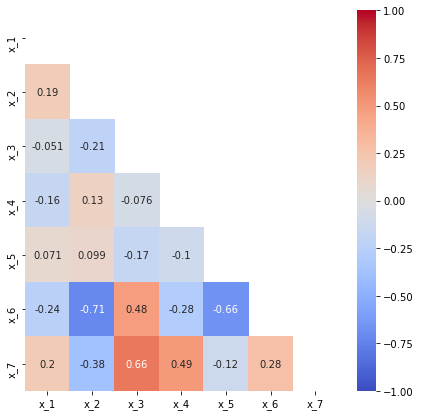

In [126]:
show_corr_matrix(data.drop(columns=["target"]), fts)

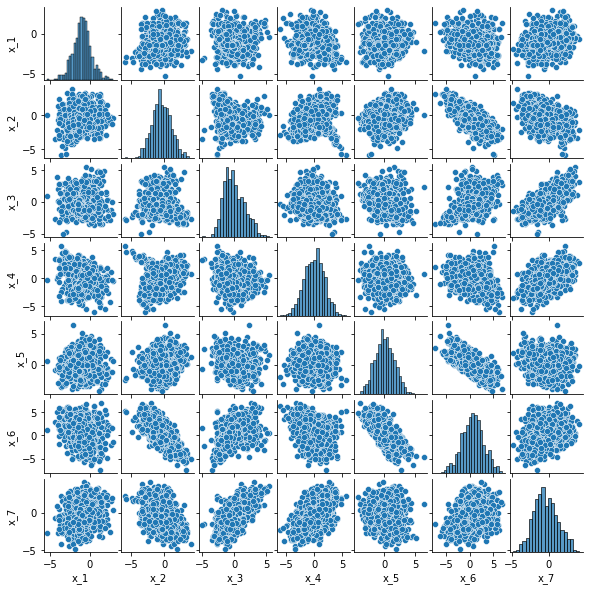

In [106]:
graph = sns.pairplot(data.drop(columns=["target"]))
graph.fig.set_size_inches(8, 8)

### Эксперименты по исследованию мультиколлинеарности
> Цель - показать влияние мультиколлинераности признаков на примере модели логистической регрессии

In [127]:
# Разделение данных на тренировочное и тестовое множество
X_train, X_test, y_train, y_test = train_test_split(
    data.copy(), y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=seed
)

### Эксперимент #1. 
> В качестве признаков используются только информативные признаки, которые по построению не обладают свойством мультиколлинеарности.

In [129]:
formula = """
    target ~ 
    + x_1
    + x_2
    + x_3
    + x_4
    + x_5 
"""
statmodel_info(formula, regularized=False, train_data=X_train, test_data=X_test, test_target=y_test)

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.377     
Dependent Variable: target           AIC:              702.6800  
Date:               2021-11-16 14:15 BIC:              730.7876  
No. Observations:   800              Log-Likelihood:   -345.34   
Df Model:           5                LL-Null:          -554.51   
Df Residuals:       794              LLR p-value:      3.3099e-88
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     11.0000                                      
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -0.1511    0.1449   -1.0421  0.2974  -0.4351   0.1330
x_1          -0.2065    0.0895   -2.3074  0.0210  -0.3819  -0.0311
x_2           0.5681    0.0766    7.4182  0.0000   0.4180   0.7183
x_3          -1.2126    0.0956

> Наблюдения: все признаки статистически значимы (при уровне значимости 0.05). Доверительные интервалы для коэффициентов достаточно узкие по сравнению с последующими экспериментами. 

### Эксперимент #2.
> К признакам из первого эксперимента добавлен один из признаков (x_6), порождающий мультиколлинеарность.

In [131]:
formula = """
    target ~ 
    + x_1
    + x_2
    + x_3
    + x_4
    + x_5
    + x_6 
"""
statmodel_info(formula, regularized=False, train_data=X_train, test_data=X_test, test_target=y_test)

                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.377     
Dependent Variable:    target             AIC:                702.6800  
Date:                  2021-11-16 14:16   BIC:                730.7876  
No. Observations:      800                Log-Likelihood:     -345.34   
Df Model:              5                  LL-Null:            -554.51   
Df Residuals:          794                LLR p-value:        3.3099e-88
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        13.0000                                          
------------------------------------------------------------------------
           Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
------------------------------------------------------------------------
Intercept -0.1510       0.1449 -1.0420 0.2974       -0.4351       0.1331
x_1       -0.2511  467261.3813 -0.0000 1.0000  -915815.7297  915815.2275
x_2    

> Наблюдения: проблемы при вычислении статистических характеристик для модели с регуляризацией. В отсутствие регуляризации наблюдается увеличение доверительных интервалов на несколько порядков по сравнению с экспериментом #1. Все признаки статистически незначимы. Значения метрик не изменились.

### Эксперимент #3. 
> К признакам из первого эксперимента добавлен второй из признаков (x_7), порождающий мультиколлинеарность.

In [132]:
formula = """
    target ~ 
    + x_1
    + x_2
    + x_3
    + x_4
    + x_5 
    + x_7
"""
statmodel_info(formula, regularized=False, train_data=X_train, test_data=X_test, test_target=y_test)

                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.377     
Dependent Variable:    target             AIC:                702.6800  
Date:                  2021-11-16 14:16   BIC:                730.7876  
No. Observations:      800                Log-Likelihood:     -345.34   
Df Model:              5                  LL-Null:            -554.51   
Df Residuals:          794                LLR p-value:        3.3099e-88
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        12.0000                                          
------------------------------------------------------------------------
           Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
------------------------------------------------------------------------
Intercept -0.1511       0.1449 -1.0421 0.2974       -0.4351       0.1330
x_1        0.1272  998623.0862  0.0000 1.0000 -1957265.1558 1957265.4102
x_2    

> Наблюдения. Аналогичные эксперименту #3. 

### Эксперимент #4. 
> В модель включены все признаки. 

In [133]:
formula = """
    target ~ 
    + x_1
    + x_2
    + x_3
    + x_4
    + x_5 
    + x_6
    + x_7
"""
statmodel_info(formula, regularized=False, train_data=X_train, test_data=X_test, test_target=y_test)

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.377     
Dependent Variable: target           AIC:              702.6800  
Date:               2021-11-16 14:16 BIC:              730.7876  
No. Observations:   800              Log-Likelihood:   -345.34   
Df Model:           5                LL-Null:          -554.51   
Df Residuals:       794              LLR p-value:      3.3099e-88
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     13.0000                                      
--------------------------------------------------------------------
              Coef.     Std.Err.     z     P>|z|    [0.025    0.975]
--------------------------------------------------------------------
Intercept    -0.1510         nan    nan      nan       nan       nan
x_1           0.0857         nan    nan      nan       nan       nan
x_2           0.1918         nan    nan      nan       nan       nan
x_3          -0.81

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


> Наблюдения. Проблемы при вычислении статистических характеристик для модели без регуляризации. Построение модели с регуляризацией завершилось с ошибкой. Значения метрик не изменились.

### Сводная таблица экспериментов
> Содержит в себе значения коэффициентов признаков для всех рассмотренных экспериментов. Также представлена информация о метриках. 

In [112]:
pd.DataFrame({
    "x_1": [-0.2065, -0.2511, 0.1272, 0.0857],
    "x_2": [0.5682, 0.4166, 0.3052, 0.1918],
    "x_3": [-1.2126, -1.1527, -0.8514, -0.8117],
    "x_4": [-0.2592, -0.3217, 0.0843, 0.0286],
    "x_5": [-0.3046, -0.4580, -0.2659, -0.3867],
    "x_6": ["-", -0.1752, "-", -0.1371],
    "x_7": ["-", "-", -0.5716, -0.5602],
    "Intercept": [-0.1511, -0.1510, -0.1510, -0.1510],
    "ROC-AUC_test": [0.890689] * 4,
    "F1-score_test": [0.816327] * 4,
}, index=["(1-5)", "(1-5) + 6", "(1-5) + 7", "(1-7)"])


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,Intercept,ROC-AUC_test,F1-score_test
(1-5),-0.2065,0.5682,-1.2126,-0.2592,-0.3046,-,-,-0.1511,0.890689,0.816327
(1-5) + 6,-0.2511,0.4166,-1.1527,-0.3217,-0.4580,-0.1752,-,-0.1510,0.890689,0.816327
(1-5) + 7,0.1272,0.3052,-0.8514,0.0843,-0.2659,-,-0.5716,-0.1510,0.890689,0.816327
(1-7),0.0857,0.1918,-0.8117,0.0286,-0.3867,-0.1371,-0.5602,-0.1510,0.890689,0.816327


   Включение в модель сильно коррелированных признаков приводит к тому, что:
* коэффициенты модели становятся неустойчивыми (см., например, знаки коэффициентов при признаках x_1 и x_4 в различных экспериментах)
* коэффициенты модели становятся статистически незначимыми (доверительные интервалы увеличиваются на несколько порядков по сравнению с интервалами при отсутствием мультиколлинеарности)
* значения метрик остаются неизменными

### Отбор признаков 
> Показано применение метода, описанного в статье, к модельной задаче.

### Вспомогательные функции

In [113]:
def get_scores(dataset, target, rnd_state=1234):
    """Returns features scores.

    Parameters
    ----------
    dataset: pd.DataFrame. Dataset with all data.
    target: array. Ground truth of target.
    rnd_state: integer. Random state.

    Returns
    -------
    scores: dictionary. Features and their scores.
    """

    scores = dict()

    for feature in dataset.columns:
        mask = ~dataset[feature].isna()
        X = dataset[mask][[feature]]
        y = target[mask]
        discr_fts_mask = X.dtypes.values == 'int64'

        score = mutual_info_classif(
            X=X,
            y=y,
            discrete_features=discr_fts_mask,
            n_neighbors=5,
            random_state=rnd_state
        )
        scores[feature] = score[0]

    return scores

In [114]:
def get_noncollinear_fts(dataset, target, trsh=0.8, mode="all", random_seed=1234, verbose=True):
    """Returns maximum linearly independent subset of features by threshold.

    Parameters
    ----------
    dataset: pd.DataFrame. Dataset with all data.
    target: array. Ground truth of target.
    trsh: float. threshold of correlation.  
    mode: string. 'all' returns all sets 'max' returns max set
    random_seed: integer. Random state.
    verbose: bool. Print steps or not

    Returns
    -------
    answer: dictionary. key - length of set, value - features and total score
    G: graph
    """

    t0 = perf_counter()

    # 1. MI calculation
    if verbose:
        print(f"=> mutual info calculation...")
    t1 = perf_counter()
    scores = get_scores(dataset, target, random_seed)
    if verbose:
        print(f"Task completed in: {timedelta(seconds=(perf_counter()-t1))}\n")

    # 2. Correlation matrix calculation
    if verbose:
        print(f"=> corr_matrix calculation...")
    t1 = perf_counter()
    corr_matrix = dataset.corr().abs()
    fts = corr_matrix.columns
    corr_matrix = np.array(corr_matrix)
    if verbose:
        print(f"Task completed in: {timedelta(seconds=(perf_counter()-t1))}\n")

    # 3. Graph assembling
    if verbose:
        print(f"=> graph assembling...")
    t1 = perf_counter()
    # Fill diagonal elements by 2. That value is greater than trashold
    np.fill_diagonal(corr_matrix, 2)
    corr_matrix = pd.DataFrame(corr_matrix, columns=fts, index=fts)
    graph_matrix = corr_matrix[abs(corr_matrix) > trsh]
    # High-correlated vertices does not connect by edge
    graph_matrix[~graph_matrix.isna()] = 0
    # Other vertices connect by edges
    graph_matrix.fillna(1, inplace=True)
    G = nx.from_numpy_matrix(np.array(graph_matrix))
    G = nx.relabel_nodes(G, dict(zip(list(G.nodes), fts)))
    if verbose:
        print(f"Task completed in: {timedelta(seconds=(perf_counter()-t1))}\n")

    # 4. Qliques search
    if verbose:
        print(f"=> qliques search...")
    t1 = perf_counter()
    clq = nx.find_cliques(G)
    cliques = list(clq)
    if verbose:
        print(f"{len(cliques)} qliques are found:\n")
    lens = np.array(list(map(len, cliques)))  # size of cliques
    stat = pd.Series(lens).value_counts()  # qliques distribution by size
    if verbose:
        print(stat)
    if verbose:
        print(f"Task completed in: {timedelta(seconds=(perf_counter()-t1))}\n")

    # 5. Optimal qlique search
    if verbose:
        print(f"=> best cliques search...")
    t1 = perf_counter()
    answer = {}
    if mode == "all":
        iter_list = sorted(np.array(stat.index))
    elif mode == "max":
        iter_list = [np.array(stat.index).max()]
    for val in iter_list:
        if verbose:
            print(f"Search best clique for dim = {val}")
        max_curr = -1e5
        fts_list = []
        for idx in np.argwhere(lens == val).ravel():
            summa = 0
            for col in cliques[idx]:
                summa += scores[col]
            if summa > max_curr:
                max_curr = summa
                fts_list = cliques[idx]
        answer[val] = (fts_list, max_curr)
    if verbose:
        print(f"Task completed in: {timedelta(seconds=(perf_counter()-t1))}\n")
    print(f"All tasks completed in: {timedelta(seconds=(perf_counter()-t0))}")

    return answer, G

In [115]:
# Поиск максимальных клик
qlq_list, G = get_noncollinear_fts(
    data.drop(columns=["target"]), y, trsh=0.65, mode="all", verbose=True)

=> mutual info calculation...
Task completed in: 0:00:00.041653

=> corr_matrix calculation...
Task completed in: 0:00:00.000695

=> graph assembling...
Task completed in: 0:00:00.001694

=> qliques search...
4 qliques are found:

4    2
5    2
dtype: int64
Task completed in: 0:00:00.000728

=> best cliques search...
Search best clique for dim = 4
Search best clique for dim = 5
Task completed in: 0:00:00.000108

All tasks completed in: 0:00:00.045368


In [116]:
# Найденные оптимальные клики и суммарное значение MI
qlq_list

{4: (['x_1', 'x_4', 'x_3', 'x_6'], 0.3202280817046079),
 5: (['x_1', 'x_4', 'x_3', 'x_5', 'x_2'], 0.3050526295822735)}

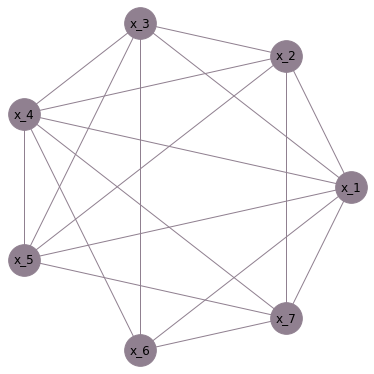

In [117]:
# Отрисовка графа для модельной задачи
plt.figure(figsize=(5, 5))
nx.draw_circular(G, with_labels=1, node_color='#908090',
                 edge_color='#908090', node_size=1000)